In [ ]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
import statsmodels.graphics.tsaplots as tsap
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import psmpy
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
import warnings
from tqdm import tqdm
import random

import doubleml as dml
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
import patsy


random.seed(123456)
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)
warnings.filterwarnings('ignore')

In [ ]:
def power_var_creater(dfr, var_list, n):
    df = dfr.copy()
    for i in var_list:
        df[i+'_power'+str(n)] = np.power(df[i], n)

    return df

def interaction_creater(dfr, var_list):
    df = dfr.copy()
    for i in tqdm(list(itertools.combinations(var_list, 2))):
        df[i[0] + '_x_'+ i[1]] = df[i[0]] * df[i[1]]
    return df

In [ ]:
working_dir = os.getcwd()
output_dir = working_dir.replace("Code", "Output")
input_dir = working_dir.replace("Code", "Data")
print(working_dir)
print(output_dir)
print(input_dir)

D:\Personal documents\LMU\Machine learning\Project\Code
D:\Personal documents\LMU\Machine learning\Project\Output
D:\Personal documents\LMU\Machine learning\Project\Data


In [ ]:
data = pd.read_csv(input_dir+'/genderinequality.csv')

In [ ]:
data.head(5)

,year,id,wage,hours,emp,treat,female,IQ,KWW,educ,...,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,2005,1,1081.50,40,1,0,1,105,42,12,...,16,37,1,0,1,1,3,4.0,NaN,NaN
1,2005,2,0.00,0,0,0,0,85,32,14,...,9,28,1,1,1,1,5,1.0,7.0,NaN
2,2005,3,773.25,40,1,0,1,112,24,14,...,5,29,1,0,0,1,4,2.0,12.0,12.0
3,2005,4,999.75,45,1,0,1,103,30,16,...,1,34,1,0,0,1,3,1.0,NaN,NaN
4,2005,5,375.00,40,1,0,1,69,18,9,...,13,38,1,1,1,1,8,6.0,6.0,NaN


In [ ]:
raw_cols = list(data.columns)
raw_cols

['year',
 'id',
 'wage',
 'hours',
 'emp',
 'treat',
 'female',
 'IQ',
 'KWW',
 'educ',
 'exper',
 'tenure',
 'age',
 'married',
 'black',
 'south',
 'urban',
 'sibs',
 'brthord',
 'meduc',
 'feduc']

# Data cleaning

In [ ]:
data.loc[data.emp == 0, 'hours'] = 0
data.loc[data.emp == 0, 'tenure'] = 0


# Variables creation

In [ ]:
#data['hrwage'] = (data.wage / data.hours).replace(np.inf, 0).fillna(0)
data['log_wage'] = np.log(data.wage).replace(-np.inf, 0)
#data['log_hrwage'] = np.log(data.hrwage).replace(-np.inf, 0)


data['educ_cat'] = pd.cut(data.educ, bins=[0, 12.5, 16.5, 20], labels=['high school', 'college', 'postgrad'])
data['highsch'] = (data.educ_cat == 'high school').astype(int)
data['college'] = (data.educ_cat == 'college').astype(int)
data['postgrad'] = (data.educ_cat == 'postgrad').astype(int)

data = data.drop('educ_cat', axis = 1)

#data['married_female'] = data.female * data.married
#data['married_male'] = (1-data.female) * data.married

data['feduc_unknown'] = data.feduc.isna().astype(int)
data['meduc_unknown'] = data.meduc.isna().astype(int)
data['brthord_unknow'] = data.brthord.isna().astype(int)

# impute missing data
data.loc[data.feduc.isna(), 'feduc'] = data.feduc.mean()
data.loc[data.meduc.isna(), 'meduc'] = data.meduc.mean()
data.loc[data.brthord.isna(), 'brthord'] = (data[data.brthord.isna()].sibs +1) /2


In [ ]:
data.columns

Index(['year', 'id', 'wage', 'hours', 'emp', 'treat', 'female', 'IQ', 'KWW',
       'educ', 'exper', 'tenure', 'age', 'married', 'black', 'south', 'urban',
       'sibs', 'brthord', 'meduc', 'feduc', 'log_wage', 'highsch', 'college',
       'postgrad', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow'],
      dtype='object')

# Long to wide

In [ ]:
data_2005 = data[data.year == 2005]
data_2010 = data[data.year == 2010]

print(data_2005.shape)
print(data_2010.shape)

(1047, 28)
(1047, 28)


In [ ]:
list(zip(data_2005.hours, data_2010.hours))

[(40, 40),
 (0, 0),
 (40, 40),
 (45, 45),
 (40, 40),
 (40, 40),
 (50, 50),
 (46, 46),
 (40, 40),
 (46, 46),
 (40, 40),
 (50, 50),
 (0, 0),
 (40, 40),
 (45, 45),
 (38, 38),
 (60, 0),
 (40, 40),
 (40, 40),
 (0, 0),
 (55, 55),
 (40, 40),
 (40, 40),
 (40, 40),
 (50, 50),
 (0, 0),
 (55, 55),
 (0, 0),
 (40, 40),
 (38, 38),
 (40, 40),
 (40, 40),
 (40, 40),
 (55, 55),
 (60, 60),
 (44, 44),
 (40, 40),
 (48, 48),
 (40, 40),
 (0, 0),
 (60, 0),
 (40, 40),
 (40, 40),
 (40, 40),
 (50, 50),
 (0, 0),
 (48, 48),
 (40, 40),
 (40, 40),
 (40, 40),
 (40, 40),
 (0, 0),
 (40, 0),
 (60, 60),
 (47, 47),
 (40, 40),
 (50, 50),
 (55, 55),
 (40, 40),
 (40, 40),
 (45, 45),
 (0, 0),
 (40, 0),
 (44, 44),
 (40, 40),
 (40, 40),
 (40, 40),
 (50, 50),
 (0, 0),
 (40, 40),
 (45, 45),
 (50, 50),
 (40, 40),
 (40, 40),
 (50, 50),
 (48, 48),
 (40, 40),
 (34, 34),
 (40, 40),
 (40, 40),
 (40, 40),
 (40, 40),
 (40, 40),
 (45, 45),
 (40, 40),
 (45, 45),
 (40, 40),
 (40, 40),
 (45, 45),
 (0, 0),
 (43, 43),
 (40, 40),
 (36, 36),
 (4

In [ ]:
data_2005_1 = data_2005.copy()
data_2010_1 = data_2010.copy()

fixed_var = ['id', 'treat', 'female', 'IQ', 'KWW','educ','black','south', 'urban','sibs', 'brthord', 'meduc', 'feduc',
            'highsch', 'college', 'postgrad', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow']
time_var = [i for i in data.columns if i not in fixed_var]


data_2005_1 = data_2005_1.rename(dict(zip(time_var, [i+'_2005' for i in time_var])))

data_2010_1 = data_2010_1.rename(dict(zip(time_var, [i+'_2010' for i in time_var])))

fixed_var.remove('id')

data_wide = data_2005_1.merge(data_2010_1, on= 'id')
data_wide = data_wide.rename(dict(zip([i+'_y' for i in fixed_var],fixed_var)), axis=1)
data_wide = data_wide.drop([i+'_x' for i in fixed_var], axis = 1)
data_wide = data_wide.rename(dict(zip([i+'_x' for i in time_var], [i+'_2005' for i in time_var])), axis=1)
data_wide = data_wide.rename(dict(zip([i+'_y' for i in time_var], [i+'_2010' for i in time_var])), axis=1)

data_wide = data_wide.drop(['year_2005', 'year_2010'], axis = 1)


In [ ]:
# reorder columns

data_wide = data_wide[['id', *fixed_var, *[i for i in data_wide.columns if i not in ['id', *fixed_var]]]]
data_wide.columns

Index(['id', 'treat', 'female', 'IQ', 'KWW', 'educ', 'black', 'south', 'urban',
       'sibs', 'brthord', 'meduc', 'feduc', 'highsch', 'college', 'postgrad',
       'feduc_unknown', 'meduc_unknown', 'brthord_unknow', 'wage_2005',
       'hours_2005', 'emp_2005', 'exper_2005', 'tenure_2005', 'age_2005',
       'married_2005', 'log_wage_2005', 'wage_2010', 'hours_2010', 'emp_2010',
       'exper_2010', 'tenure_2010', 'age_2010', 'married_2010',
       'log_wage_2010'],
      dtype='object')

## Data cleaning

In [ ]:
# for some individuals which tenure_2010 > 5, their (tenure_2010 - tenure_2005) <4.  I assume the tenure_2005 is correctly reported

cond1 = data_wide.tenure_2010 >5
cond2 = data_wide.emp_2010 != 0

data_wide.loc[cond1 & cond2, 'tenure_2010'] = data_wide[cond1 & cond2].tenure_2005 + 4

In [ ]:
(data_wide.married_2010 - data_wide.married_2005).value_counts()

 0    1016
-1      31
dtype: int64

In [ ]:
data_2005.index = data_2005.id
data_2010.index =data_2010.id

for i in fixed_var:
    print((data_2010[i] - data_2010[i]).value_counts())

0    1047
Name: treat, dtype: int64
0    1047
Name: female, dtype: int64
0    1047
Name: IQ, dtype: int64
0    1047
Name: KWW, dtype: int64
0    1047
Name: educ, dtype: int64
0    1047
Name: black, dtype: int64
0    1047
Name: south, dtype: int64
0    1047
Name: urban, dtype: int64
0    1047
Name: sibs, dtype: int64
0.0    1047
Name: brthord, dtype: int64
0.0    1047
Name: meduc, dtype: int64
0.0    1047
Name: feduc, dtype: int64
0    1047
Name: highsch, dtype: int64
0    1047
Name: college, dtype: int64
0    1047
Name: postgrad, dtype: int64
0    1047
Name: feduc_unknown, dtype: int64
0    1047
Name: meduc_unknown, dtype: int64
0    1047
Name: brthord_unknow, dtype: int64


In [ ]:

descr_summ_wide = data_wide.describe().transpose().drop(['25%', '75%'], axis = 1)
descr_summ_wide.to_excel(output_dir+'//descriptive summary_wide.xlsx')


# Test for randomization

In [ ]:
treated_id = list(data_2010[data_2010.treat == 1].id)
data_2005['treated_2007'] = data_2005.id.apply(lambda x: x in treated_id)
data_2010['treated_2007'] = data_2010.id.apply(lambda x: x in treated_id)

In [ ]:
data_2005['treated_2007'].value_counts()

False    681
True     366
Name: treated_2007, dtype: int64

In [ ]:
new_var = ['log_wage', 'log_hrwage', '']



In [ ]:
cond1 = data_2005.treated_2007 == 0
cond2 = data_2005.treated_2007 == 1

mean_treated_2005 = data_2005[cond2].describe().loc['mean']
mean_untreated_2005 = data_2005[cond1].describe().loc['mean']

mean_treated_2005.name = 'mean_treated'
mean_untreated_2005.name = 'mean_untreated'


result1 = []
for i in data.columns:
    model = ols('{} ~ treated_2007'.format(i), data=data_2005).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    result1.append(anova_table['PR(>F)'][0])

In [ ]:
did_emp = data_wide.groupby(['treat', 'female']).mean()[['emp_2005', 'emp_2010']]
did_emp['Difference'] = did_emp.emp_2010 - did_emp.emp_2005
did_emp

emp_2005  emp_2010  Difference
treat female                                
0     0       0.884706  0.861176   -0.023529
      1       0.894531  0.878906   -0.015625
1     0       0.908257  0.880734   -0.027523
      1       0.898833  0.883268   -0.015564

array([<AxesSubplot:title={'center':'emp_2005'}, xlabel='[treat, female]'>,
       <AxesSubplot:title={'center':'emp_2010'}, xlabel='[treat, female]'>],
      dtype=object)

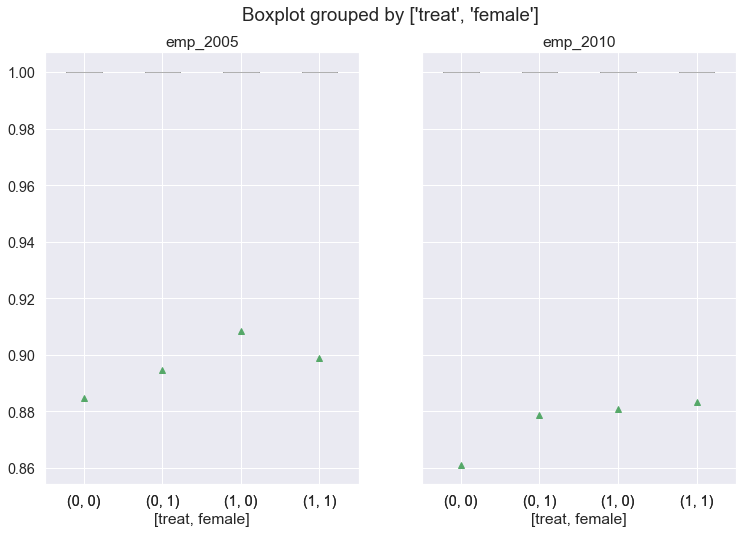

In [ ]:
data_wide.boxplot(['emp_2005', 'emp_2010'], by=['treat', 'female'],
                                           showfliers = False, showmeans = True, figsize=[12,8])

In [ ]:
did_wage = data_wide.groupby(['treat', 'female']).mean()[['wage_2005', 'wage_2010']]
did_wage['Difference'] = did_wage.wage_2010 - did_wage.wage_2005
did_wage

wage_2005    wage_2010  Difference
treat female                                     
0     0       828.277647  1043.959794  215.682147
      1       650.408203   833.102290  182.694086
1     0       851.660550  1085.637345  233.976794
      1       667.774319  1166.622472  498.848153

In [ ]:
pd.concat([did_emp, did_wage], axis=1).to_excel(output_dir+'\did.xlsx')

In [ ]:
data[data.emp == 0].hours.value_counts()

0    245
Name: hours, dtype: int64

array([<AxesSubplot:title={'center':'wage_2005'}, xlabel='[treat, female]'>,
       <AxesSubplot:title={'center':'wage_2010'}, xlabel='[treat, female]'>],
      dtype=object)

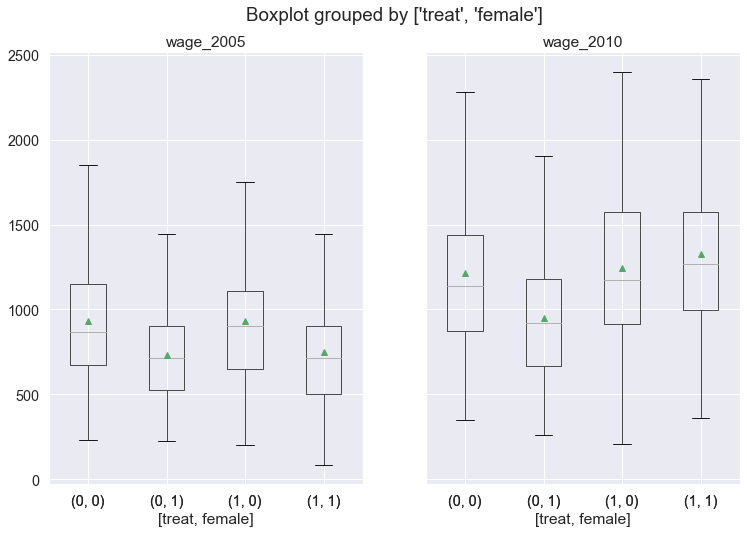

In [ ]:
data_wide[(data_wide.emp_2005 == 1) & (data_wide.emp_2010 == 1)].boxplot(['wage_2005', 'wage_2010'], by=['treat', 'female'], showfliers = False, showmeans = True, figsize=[12,8])

In [ ]:
cond_e_2005 = data_wide.emp_2005 == 1
cond_e_2010 = data_wide.emp_2010 == 1
cond_t = data_wide.treat == 1
cond_f = data_wide.female == 1

label_list = ['Untreated male', 'Untreated female','Treated male', 'Treated female']

b_data_2005 = [data_wide[cond_e_2005 & ~cond_t & ~cond_f].wage_2005, data_wide[cond_e_2005 & ~cond_t & cond_f].wage_2005,
          data_wide[cond_e_2005 & cond_t & ~cond_f].wage_2005, data_wide[cond_e_2005 & cond_t & cond_f].wage_2005]

b_data_2010 = [data_wide[cond_e_2010 & ~cond_t & ~cond_f].wage_2010, data_wide[cond_e_2010 & ~cond_t & cond_f].wage_2010,
          data_wide[cond_e_2010 & cond_t & ~cond_f].wage_2010, data_wide[cond_e_2010 & cond_t & cond_f].wage_2010]

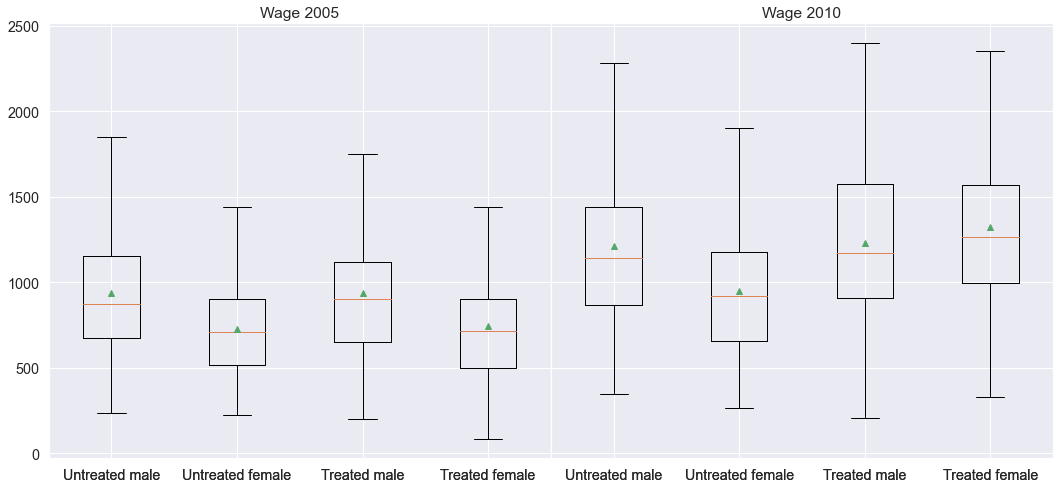

In [ ]:


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,8), sharex=True)


ax1.boxplot(b_data_2005, showfliers = False, showmeans = True, labels=label_list)
ax2.boxplot(b_data_2010, showfliers = False, showmeans = True, labels=label_list)

ax1.set_title('Wage 2005')
ax2.set_title('Wage 2010')



f.subplots_adjust(wspace=0, hspace=0)


plt.savefig(output_dir+'//boxplot_wage.svg')

In [ ]:
balance_check = pd.DataFrame([mean_treated_2005, mean_untreated_2005]).transpose()
balance_check['Mean Difference'] = balance_check.mean_treated - balance_check.mean_untreated
balance_check['ANOVA P Value'] = result1

balance_check.round(decimals=2)
balance_check['ANOVA P Value'] = balance_check['ANOVA P Value'].round(decimals=5)

balance_check = balance_check.drop(['year', 'id', 'log_wage', 'treat'])
balance_check.to_excel(output_dir+'//balance_table.xlsx')
balance_check

,mean_treated,mean_untreated,Mean Difference,ANOVA P Value
wage,722.538251,761.413363,-38.875111,0.16559
hours,39.816940,38.914831,0.902109,0.36016
emp,0.901639,0.888399,0.013240,0.50912
female,0.702186,0.375918,0.326268,0.00000
IQ,101.530055,101.255507,0.274548,0.77773
KWW,35.937158,35.785609,0.151549,0.76421
educ,13.382514,13.574156,-0.191642,0.18082
exper,11.721311,11.503671,0.217640,0.43599
tenure,6.308743,6.541850,-0.233107,0.49699
age,33.092896,33.096916,-0.004020,0.98407


In [ ]:
data_wide

,id,treat,female,IQ,KWW,educ,black,south,urban,sibs,...,married_2005,log_wage_2005,wage_2010,hours_2010,emp_2010,exper_2010,tenure_2010,age_2010,married_2010,log_wage_2010
0,1,0,1,105,42,12,0,1,1,3,...,1,6.986104,1446.378622,40,1,13,20,42,1,7.276818
1,2,1,0,85,32,14,1,1,1,5,...,1,0.000000,0.000000,0,0,9,0,33,1,0.000000
2,3,0,1,112,24,14,0,0,1,4,...,1,6.650602,956.093425,40,1,10,9,34,1,6.862856
3,4,0,1,103,30,16,0,0,1,3,...,1,6.907505,1376.737086,45,1,8,3,39,1,7.227472
4,5,0,1,69,18,9,1,1,1,8,...,1,5.926926,654.090458,40,1,21,17,43,1,6.483246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1043,0,1,82,33,18,0,0,1,2,...,0,5.906723,479.221254,49,1,9,12,36,0,6.172162
1043,1044,1,1,101,41,12,0,0,1,1,...,1,6.599870,1264.218137,40,1,4,16,41,1,7.142209
1044,1045,0,0,114,50,18,0,0,1,2,...,1,0.000000,0.000000,0,0,8,0,43,1,0.000000
1045,1046,1,1,115,45,17,0,0,1,3,...,1,6.993015,1600.707821,45,1,4,11,35,1,7.378201


In [ ]:
# test selection on observable

indep_var =  sm.add_constant(data_2005[['wage', 'hours', 'emp', 'female', 'IQ', 'KWW',
       'educ', 'exper', 'tenure', 'age', 'married', 'black', 'south', 'urban',
       'sibs', 'brthord', 'meduc', 'feduc', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow']])

logit_mod = sm.Logit(data_2005.treated_2007, indep_var)
logit_mod.fit().summary()

Optimization terminated successfully.
         Current function value: 0.591018
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           treated_2007   No. Observations:                 1047
Model:                          Logit   Df Residuals:                     1025
Method:                           MLE   Df Model:                           21
Date:                Mon, 31 Jul 2023   Pseudo R-squ.:                 0.08678
Time:                        17:45:15   Log-Likelihood:                -618.80
converged:                       True   LL-Null:                       -677.60
Covariance Type:            nonrobust   LLR p-value:                 1.961e-15
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0992      1.146      0.086      0.931      -2.148       2.346
wage               0.0002      0.000      0.993      0.321      -0.000       0.001
hours              0.0090      0.010      0.890      0.374      -0.011       0.029
emp               -0.3924      0.563     -0.697      0.486      -1.495       0.710
female             1.4493      0.151      9.615      0.000       1.154       1.745
IQ                 0.0038      0.006      0.632      0.527      -0.008       0.016
KWW                0.0004      0.012      0.036      0.971      -0.023       0.024
educ              -0.0718      0.045     -1.591      0.112      -0.160       0.017
exper              0.0025      0.022      0.114      0.909      -0.040       0.045
tenure            -0.0120      0.015     -0.792      0.428      -0.042       0.018
age               -0.0233      0.030     -0.774      0.439      -0.082       0.036
married           -0.1863      0.236     -0.790      0.430      -0.649       0.276
black              0.0751      0.248      0.303      0.762      -0.411       0.562
south              0.0602      0.155      0.388      0.698      -0.244       0.364
urban              0.0991      0.161      0.614      0.539      -0.217       0.416
sibs              -0.0108      0.042     -0.258      0.796      -0.093       0.071
brthord           -0.0390      0.059     -0.663      0.508      -0.154       0.076
meduc             -0.0107      0.031     -0.342      0.732      -0.072       0.051
feduc             -0.0014      0.029     -0.049      0.961      -0.059       0.056
feduc_unknown      0.3174      0.188      1.687      0.092      -0.051       0.686
meduc_unknown     -0.2044      0.276     -0.740      0.459      -0.746       0.337
brthord_unknow    -0.4197      0.260     -1.614      0.107      -0.929       0.090
==================================================================================
"""

In [ ]:
list(zip(data_wide.tenure_2005,  data_wide.tenure_2010, list(data_wide.tenure_2010 - data_wide.tenure_2005)))

[(16, 20, 4),
 (0, 0, 0),
 (5, 9, 4),
 (1, 3, 2),
 (13, 17, 4),
 (16, 20, 4),
 (3, 5, 2),
 (16, 20, 4),
 (8, 12, 4),
 (16, 20, 4),
 (4, 5, 1),
 (2, 6, 4),
 (0, 0, 0),
 (1, 4, 3),
 (5, 9, 4),
 (8, 12, 4),
 (10, 0, -10),
 (7, 11, 4),
 (9, 13, 4),
 (0, 0, 0),
 (12, 16, 4),
 (10, 14, 4),
 (1, 3, 2),
 (12, 16, 4),
 (14, 18, 4),
 (0, 0, 0),
 (2, 6, 4),
 (0, 0, 0),
 (14, 18, 4),
 (10, 14, 4),
 (3, 7, 4),
 (14, 18, 4),
 (15, 19, 4),
 (5, 9, 4),
 (13, 17, 4),
 (10, 14, 4),
 (16, 20, 4),
 (11, 15, 4),
 (3, 7, 4),
 (0, 0, 0),
 (2, 0, -2),
 (4, 5, 1),
 (5, 9, 4),
 (4, 8, 4),
 (8, 12, 4),
 (0, 0, 0),
 (4, 8, 4),
 (13, 17, 4),
 (13, 17, 4),
 (7, 11, 4),
 (14, 18, 4),
 (0, 0, 0),
 (1, 0, -1),
 (2, 4, 2),
 (13, 17, 4),
 (2, 4, 2),
 (3, 7, 4),
 (5, 9, 4),
 (18, 22, 4),
 (0, 4, 4),
 (1, 3, 2),
 (0, 0, 0),
 (5, 0, -5),
 (12, 16, 4),
 (4, 8, 4),
 (14, 18, 4),
 (2, 3, 1),
 (14, 18, 4),
 (0, 0, 0),
 (9, 13, 4),
 (6, 10, 4),
 (9, 13, 4),
 (1, 4, 3),
 (7, 11, 4),
 (12, 16, 4),
 (1, 2, 1),
 (12, 16, 4),
 (3, 3

<AxesSubplot:>

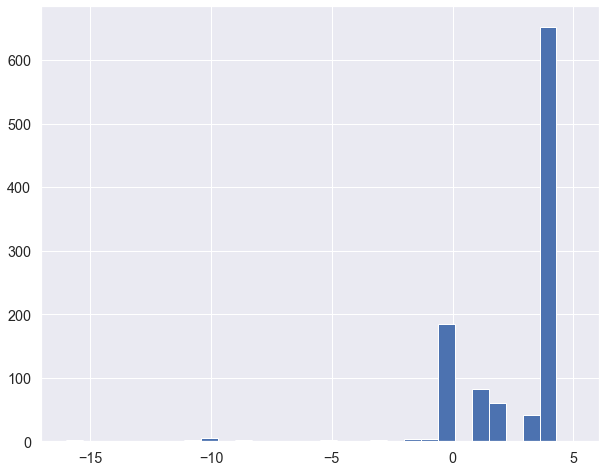

In [ ]:
(data_wide.tenure_2010 - data_wide.tenure_2005).hist(bins = 30)

# Double ML

In [ ]:
data_wide.columns

Index(['id', 'treat', 'female', 'IQ', 'KWW', 'educ', 'black', 'south', 'urban',
       'sibs', 'brthord', 'meduc', 'feduc', 'highsch', 'college', 'postgrad',
       'feduc_unknown', 'meduc_unknown', 'brthord_unknow', 'wage_2005',
       'hours_2005', 'emp_2005', 'exper_2005', 'tenure_2005', 'age_2005',
       'married_2005', 'log_wage_2005', 'wage_2010', 'hours_2010', 'emp_2010',
       'exper_2010', 'tenure_2010', 'age_2010', 'married_2010',
       'log_wage_2010'],
      dtype='object')

In [ ]:
data_used = data_wide.copy()

In [ ]:
# for the groupped ATE

female_cond = data_used.female == 1
black_cond = data_used.black == 1
urban_cond = data_used.urban == 1
south_cond = data_used.south == 1
married_cond = data_used.married_2010 == 1
highsch = data_used.highsch == 1
college = data_used.college == 1
postgrad = data_used.postgrad == 1



by_gender = pd.DataFrame()
by_gender['male'] = ~female_cond
by_gender['female'] = female_cond


by_gender_black = pd.DataFrame()
by_gender_black['Black male'] = (~female_cond) & (black_cond)
by_gender_black['Non-black male'] = (~female_cond) & (~black_cond)
by_gender_black['Black female'] = (female_cond) & (black_cond)
by_gender_black['Non-black female'] = (female_cond) & (~black_cond)

by_gender_urban = pd.DataFrame()
by_gender_urban['Urban male'] = (~female_cond) & (urban_cond)
by_gender_urban['Non-urban male'] = (~female_cond) & (~urban_cond)
by_gender_urban['Urban female'] = (female_cond) & (urban_cond)
by_gender_urban['Non-urban female'] = (female_cond) & (~urban_cond)

by_gender_south = pd.DataFrame()
by_gender_south['Southen male'] = (~female_cond) & (south_cond)
by_gender_south['Northen male'] = (~female_cond) & (~south_cond)
by_gender_south['Southen female'] = (female_cond) & (south_cond)
by_gender_south['Northen female'] = (female_cond) & (~south_cond)

by_gender_married = pd.DataFrame()
by_gender_married['Married male'] = (~female_cond) & (married_cond)
by_gender_married['Single male'] = (~female_cond) & (~married_cond)
by_gender_married['Married female'] = (female_cond) & (married_cond)
by_gender_married['Single female'] = (female_cond) & (~married_cond)


by_gender_educ = pd.DataFrame()
by_gender_educ['Male - high school'] = (~female_cond) & (highsch)
by_gender_educ['Male - college'] = (~female_cond) & (college)
by_gender_educ['Male - postgrad'] = (~female_cond) & (postgrad)
by_gender_educ['Female - high school'] = (female_cond) & (highsch)
by_gender_educ['Female - college'] = (female_cond) & (college)
by_gender_educ['Female - postgrad'] = (female_cond) & (postgrad)


In [ ]:
data_used = data_wide.copy()
data_used = data_used[data_used.emp_2010 == 1]

outcome_var_hrwage = 'log_wage_2010'
exclude_var_hrwage = ['log_wage_2010', 'wage_2010', 'emp_2010']
dummy_var_hrwage = ['treat', 'female', 'black', 'south', 'urban', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow',
            'married_2005', 'married_2010', 'same_firm_2010', 'highsch', 'college', 'postgrad']
confounder_base_hrwage = [i for i in data_wide.columns if i not in ['id', 'treat', 'educ_cat', outcome_var_hrwage, *exclude_var_hrwage]]
data_hrwage = power_var_creater(data_used, confounder_base_hrwage, 2)
data_hrwage = interaction_creater(data_hrwage, confounder_base_hrwage)

confounder_hrwage = [i for i in data_hrwage.columns if i not in ['id', 'treat', outcome_var_hrwage, *exclude_var_hrwage]]
confounder_hrwage_base = [i for i in data_used.columns if i not in ['id', 'treat', outcome_var_hrwage, *exclude_var_hrwage]]

100%|████████████████████████████████████████████| 435/435 [00:04<00:00, 89.05it/s]


In [ ]:
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

lasso_reg = LassoCV(cv=5)
logit_class = LogisticRegressionCV(penalty='l1', solver = 'saga', cv=5) # Penality l1: LASSO, penality l2: Ridge , elasticnet: Elasitc net



data_dml_hrwage = dml.DoubleMLData(data_hrwage, y_col = outcome_var_hrwage, d_cols = 'treat', x_cols = confounder_hrwage)

dml_hrwage = dml.DoubleMLIRM(data_dml_hrwage, ml_g=randomForest_reg, ml_m=randomForest_class,
                          trimming_threshold=0.01, n_folds=5, apply_cross_fitting = True, n_rep  = 1,
                          normalize_ipw = True)

In [ ]:
%%time

dml_hrwage.fit(store_predictions=True, n_jobs_cv=-1)

print(dml_hrwage.evaluate_learners())

{'ml_g0': array([[0.07291803]]), 'ml_g1': array([[0.25529068]]), 'ml_m': array([[0.47536179]])}
CPU times: total: 31.2 ms
Wall time: 50.4 s


In [ ]:
print(dml_hrwage)

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: log_wage_2010
Treatment variable(s): ['treat']
Covariates: ['female', 'IQ', 'KWW', 'educ', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc', 'highsch', 'college', 'postgrad', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow', 'wage_2005', 'hours_2005', 'emp_2005', 'exper_2005', 'tenure_2005', 'age_2005', 'married_2005', 'log_wage_2005', 'hours_2010', 'exper_2010', 'tenure_2010', 'age_2010', 'married_2010', 'female_power2', 'IQ_power2', 'KWW_power2', 'educ_power2', 'black_power2', 'south_power2', 'urban_power2', 'sibs_power2', 'brthord_power2', 'meduc_power2', 'feduc_power2', 'highsch_power2', 'college_power2', 'postgrad_power2', 'feduc_unknown_power2', 'meduc_unknown_power2', 'brthord_unknow_power2', 'wage_2005_power2', 'hours_2005_power2', 'emp_2005_power2', 'exper_2005_power2', 'tenure_2005_power2', 'age_2005_power2', 'married_2005_power2'

In [ ]:
print(dml_hrwage.cate(data_hrwage[['female']]))

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
           coef   std err          t         P>|t|    [0.025    0.975]
female  0.34693  0.029498  11.761185  7.776908e-30  0.289038  0.404821


100%|████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.74it/s]


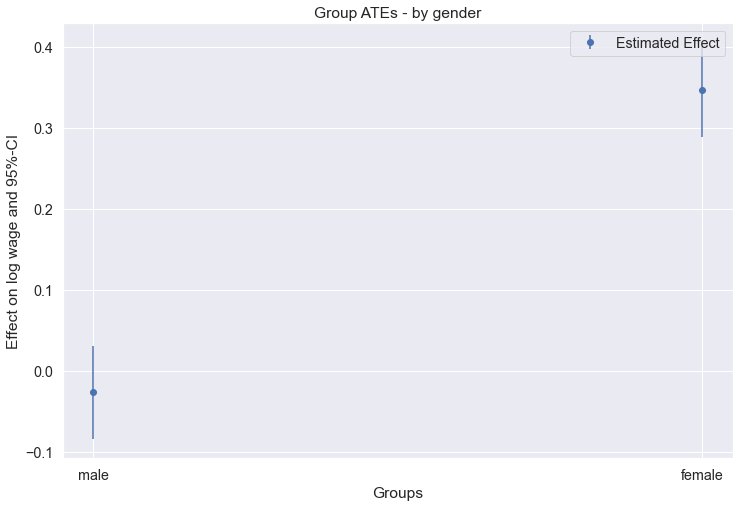

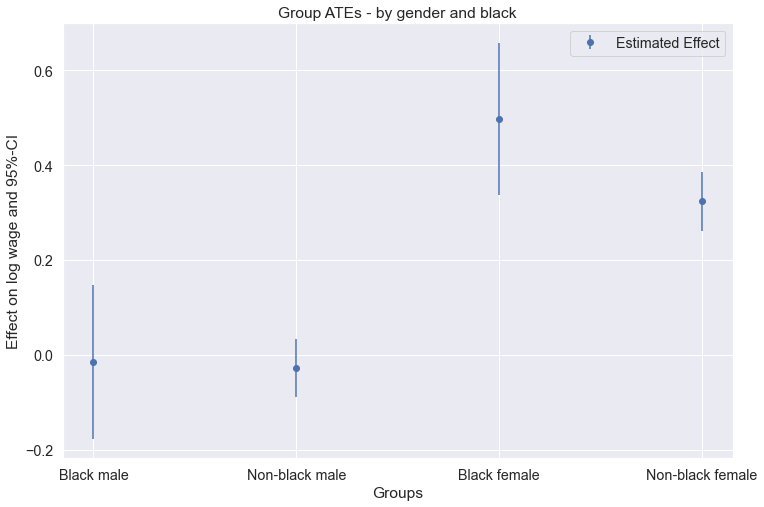

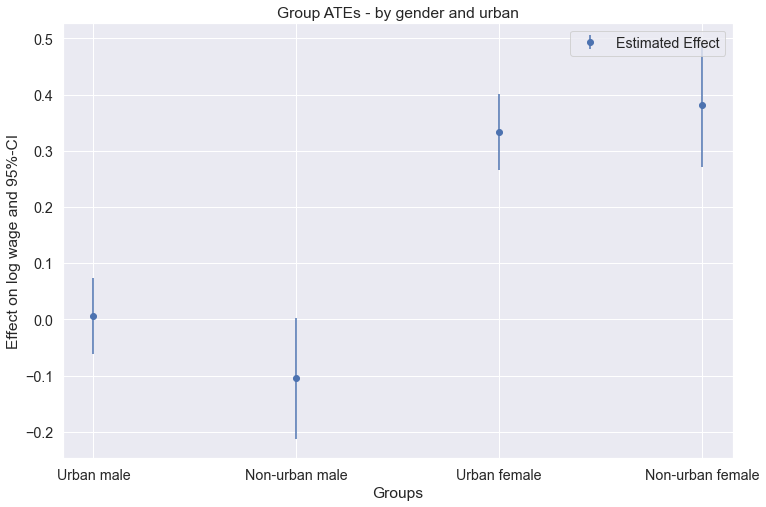

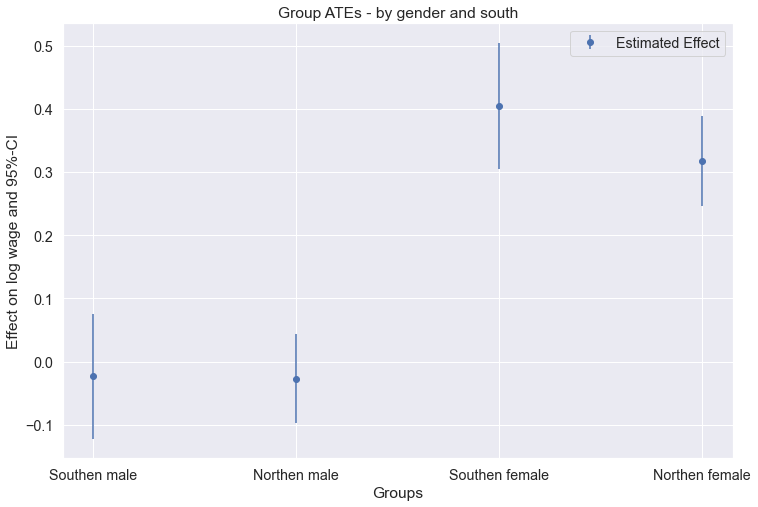

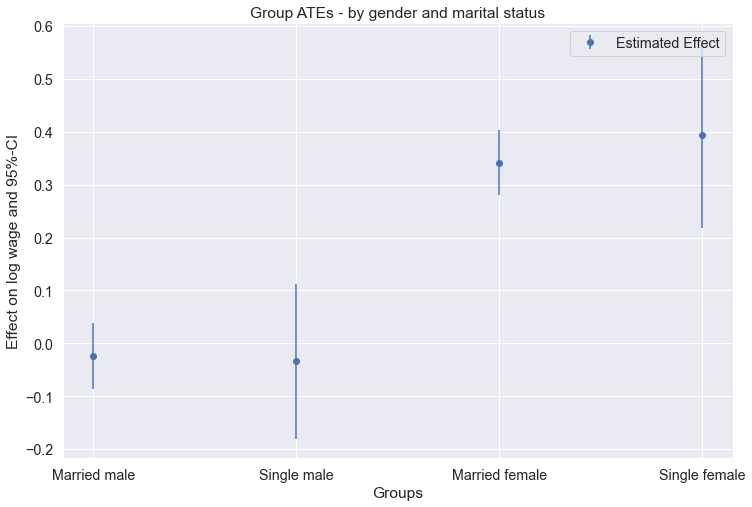

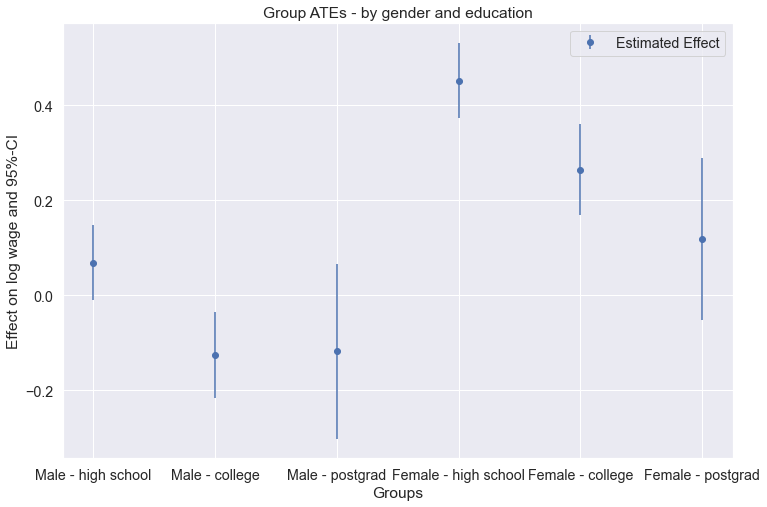

In [ ]:
filtered_index = data_hrwage.index

groups_dict = {'by gender': by_gender.iloc[filtered_index],
               'by gender and black': by_gender_black.iloc[filtered_index],
               'by gender and urban': by_gender_urban.iloc[filtered_index],
               'by gender and south': by_gender_south.iloc[filtered_index],
               'by gender and marital status': by_gender_married.iloc[filtered_index],
               'by gender and education': by_gender_educ.iloc[filtered_index]}
sum_list = []
fig_list = []

for i in tqdm(groups_dict.keys()):
    gate = dml_hrwage.gate(groups=groups_dict[i])
    summary = gate.summary
    fig = plt.figure(figsize=(12,8))

    errors = np.full((2, summary.shape[0]), np.nan)
    errors[0, :] = summary['coef'] - summary['[0.025']
    errors[1, :] = summary['0.975]'] - summary['coef']

    plt.errorbar(summary.index, summary.coef, fmt='o', yerr=errors, label='Estimated Effect')


    plt.title('Group ATEs - '+ i)
    plt.xlabel('Groups')
    plt.legend()
    plt.ylabel('Effect on log wage and 95%-CI')
    plt.savefig(output_dir+'\\Effect on log wage'+i+'.svg')

    sum_list.append(summary)
    fig_list.append(fig)



In [ ]:
gate_hrwage = pd.concat(sum_list)
gate_hrwage.to_excel(output_dir+'//GATE log wage.xlsx')
gate_hrwage

,coef,std err,t,P>|t|,[0.025,0.975]
male,-0.025974,0.029180,-0.890133,3.736291e-01,-0.083242,0.031294
female,0.346930,0.029501,11.759848,7.922775e-30,0.289032,0.404828
Black male,-0.014335,0.082269,-0.174250,8.617075e-01,-0.175794,0.147123
Non-black male,-0.027645,0.031172,-0.886871,3.753828e-01,-0.088822,0.033531
Black female,0.497287,0.081569,6.096544,1.599690e-09,0.337203,0.657372
Non-black female,0.324357,0.031605,10.262890,1.855501e-23,0.262330,0.386384
Urban male,0.005683,0.034499,0.164717,8.692033e-01,-0.062024,0.073389
Non-urban male,-0.105116,0.054547,-1.927073,5.428158e-02,-0.212169,0.001936
Urban female,0.333694,0.034656,9.628621,5.804342e-21,0.265678,0.401710
Non-urban female,0.381554,0.056054,6.806959,1.807503e-11,0.271545,0.491563


In [ ]:
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

lasso_reg = LassoCV(cv=5)
logit_class = LogisticRegressionCV(penalty='l1', solver = 'saga', cv=5) # Penality l1: LASSO, penality l2: Ridge , elasticnet: Elasitc net


data_hrwage_f = data_hrwage[data_hrwage.female == 1]
data_dml_hrwage_f = dml.DoubleMLData(data_hrwage_f, y_col = outcome_var_hrwage, d_cols = 'treat', x_cols = confounder_hrwage)

dml_hrwage_f = dml.DoubleMLIRM(data_dml_hrwage_f, ml_g=randomForest_reg, ml_m=randomForest_class,
                          trimming_threshold=0.01, n_folds=5, apply_cross_fitting = True, n_rep  = 1,
                          normalize_ipw = True)

In [ ]:
%%time

dml_hrwage_f.fit(store_predictions=True, n_jobs_cv=-1)

print(dml_hrwage_f.evaluate_learners())

{'ml_g0': array([[0.07994791]]), 'ml_g1': array([[0.21534688]]), 'ml_m': array([[0.52009241]])}
CPU times: total: 0 ns
Wall time: 26.6 s


In [ ]:
print(dml_hrwage_f)

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: log_wage_2010
Treatment variable(s): ['treat']
Covariates: ['female', 'IQ', 'KWW', 'educ', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc', 'highsch', 'college', 'postgrad', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow', 'wage_2005', 'hours_2005', 'emp_2005', 'exper_2005', 'tenure_2005', 'age_2005', 'married_2005', 'log_wage_2005', 'hours_2010', 'exper_2010', 'tenure_2010', 'age_2010', 'married_2010', 'female_power2', 'IQ_power2', 'KWW_power2', 'educ_power2', 'black_power2', 'south_power2', 'urban_power2', 'sibs_power2', 'brthord_power2', 'meduc_power2', 'feduc_power2', 'highsch_power2', 'college_power2', 'postgrad_power2', 'feduc_unknown_power2', 'meduc_unknown_power2', 'brthord_unknow_power2', 'wage_2005_power2', 'hours_2005_power2', 'emp_2005_power2', 'exper_2005_power2', 'tenure_2005_power2', 'age_2005_power2', 'married_2005_power2'

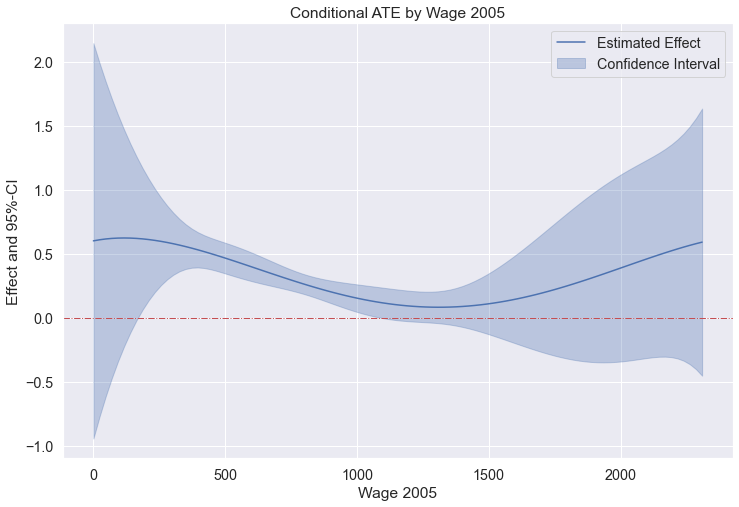

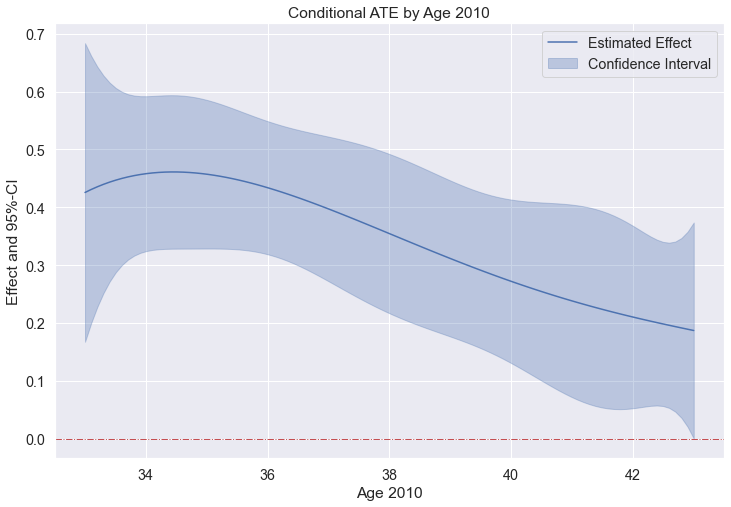

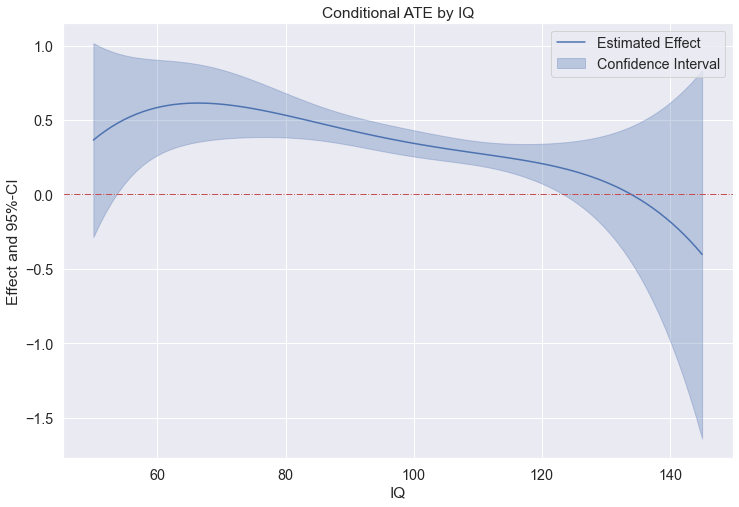

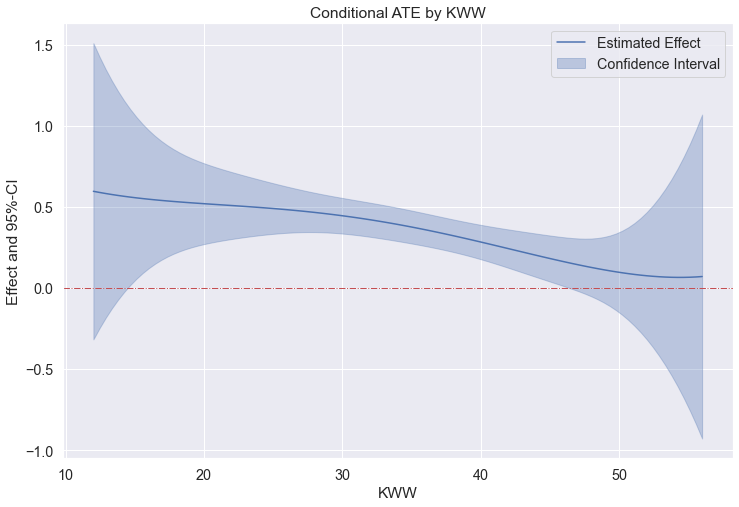

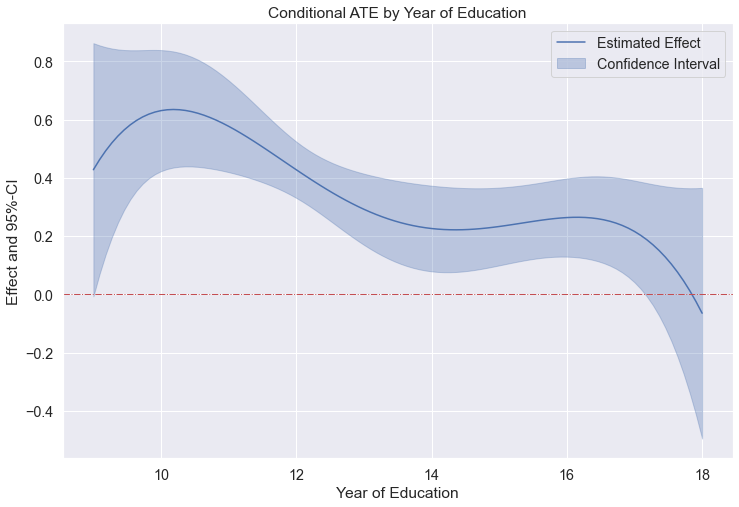

In [ ]:
var_list = ['wage_2005', 'age_2010', 'IQ', 'KWW', 'educ']

title_dict = dict(zip(var_list, ['Wage 2005', 'Age 2010', 'IQ', 'KWW', 'Year of Education']))

cate_list = []

for var in var_list:
    # 4 degree polynomial with 4 degree of freedom

    design_matrix = patsy.dmatrix("bs(x, df=4, degree=4)", {"x":data_hrwage_f[var]})
    spline_basis = pd.DataFrame(design_matrix)
    cate = dml_hrwage_f.cate(spline_basis)
    cate_list.append(dml_hrwage_f.cate(data_hrwage_f[[var]]))

    new_data = {"x": np.linspace(data_hrwage_f[var].min(), data_hrwage_f[var].max(), 100)}
    spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data, NA_action='drop')[0])
    df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)


    plt.rcParams['figure.figsize'] = 10., 7.5

    df_cate['x'] = new_data['x']
    fig = plt.figure(figsize=(12,8))
    plt.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
    plt.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')
    plt.axhline(y = 0, linestyle = '-.', linewidth = 1, color = 'r')
    plt.legend()
    plt.title('Conditional ATE'+' by '+ title_dict[var])
    plt.xlabel(var)
    plt.ylabel('Effect and 95%-CI')
    plt.xlabel(title_dict[var])
    plt.savefig(output_dir+'\\CATE'+var+'.svg')

In [ ]:
[print(i) for i in cate_list]

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
               coef   std err          t         P>|t|    [0.025    0.975]
wage_2005  0.000322  0.000026  12.621567  1.736770e-31  0.000272  0.000372
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
              coef   std err          t         P>|t|    [0.025    0.975]
age_2010  0.008544  0.000473  18.068163  2.696609e-55  0.007615  0.009474
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
        coef   std err          t         P>|t|    [0.025    0.975]
IQ  0.003069  0.000181  16.921108  4.348878e-50  0.002713  0.003426
================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
         coef   std err          t         P>|t|    [0.025   0.975]
KWW  0.008237  0.000515  15.979891  7.173414e-46  0.007224  0.0092

[None, None, None, None, None]

In [ ]:
d_wage_cate = data_wide.merge(dml_hrwage.cate(data_hrwage[['wage_2005', 'black', 'female', 'south', 'IQ', 'KWW']]).confint(), left_index = True, right_index=True)

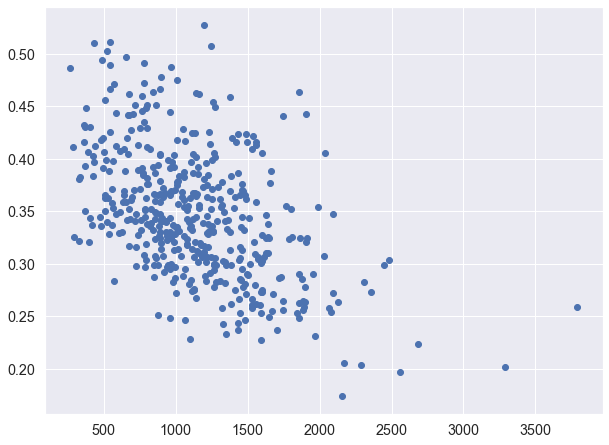

In [ ]:
plt.scatter(d_wage_cate[d_wage_cate.female == 1]['wage_2010'], d_wage_cate[d_wage_cate.female == 1].effect)

## Sensitative

In [ ]:
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

lasso_reg = LassoCV(cv=5)
logit_class = LogisticRegressionCV(penalty='l1', solver = 'saga', cv=5) # Penality l1: LASSO, penality l2: Ridge , elasticnet: Elasitc net


data_dml_hrwage = dml.DoubleMLData(data_hrwage, y_col = outcome_var_hrwage, d_cols = 'treat', x_cols = confounder_hrwage)
data_dml_hrwage_base = dml.DoubleMLData(data_hrwage, y_col = outcome_var_hrwage, d_cols = 'treat', x_cols = confounder_hrwage_base)

#dml_hrwage = dml.DoubleMLIRM(data_dml_hrwage, ml_g=randomForest_reg, ml_m=randomForest_class,
#                          trimming_threshold=0.01, n_folds=5, apply_cross_fitting = True, n_rep  = 1,
#                          normalize_ipw = True)

d_dict_wage = {'Basic': data_dml_hrwage_base, 'Flexible': data_dml_hrwage}
model_dict = {'Double forest': [randomForest_reg, randomForest_class], 'Forest + LASSO': [randomForest_reg, logit_class],
              'LASSO + Forest': [lasso_reg, randomForest_class], 'Double LASSO': [lasso_reg, logit_class]}



In [ ]:
filtered_index

Int64Index([   0,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1033, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1045, 1046],
           dtype='int64', length=914)

In [ ]:
filtered_index = data_hrwage.index

name_list_wage = []
summ_list_wage = []
rmse_list_wage = []

for i in d_dict_wage.keys():
    for j in tqdm(model_dict.keys()):
        model = dml.DoubleMLIRM(d_dict_wage[i], ml_g=model_dict[j][0], ml_m=model_dict[j][1],
                          trimming_threshold=0.01, n_folds=5, apply_cross_fitting = True, n_rep  = 1)
        fit = model.fit(store_predictions=True, n_jobs_cv=-1)
        summ = fit.gate(groups=groups_dict['by gender'].iloc[:]).summary
        rmse = fit.evaluate_learners()

        name_list_wage.append((i, j))
        summ_list_wage.append(summ)
        rmse_list_wage.append(rmse)

100%|████████████████████████████████████████████████| 4/4 [03:23<00:00, 50.95s/it]


In [ ]:
sensitative_summary_wage = {'Data': [i[0] for i in name_list_wage], 'Model': [i[1] for i in name_list_wage],
                      'coef-male':[i.loc['male', 'coef'] for i in summ_list_wage],
                      'SE-male':[i.loc['male', 'std err'] for i in summ_list_wage],
                      'coef-female':[i.loc['female', 'coef'] for i in summ_list_wage],
                      'SE-female':[i.loc['female', 'std err'] for i in summ_list_wage],
                      'Out of sample RMSE - g0': [i['ml_g0'][0][0] for i in rmse_list_wage],
                      'Out of sample RMSE - g1': [i['ml_g1'][0][0] for i in rmse_list_wage],
                      'Out of sample RMSE - m': [i['ml_m'][0][0] for i in rmse_list_wage]}


sensitative_summary_df_wage = pd.DataFrame(sensitative_summary_wage)
sensitative_summary_df_wage['Male-female Difference'] = sensitative_summary_df_wage['coef-female'] - sensitative_summary_df_wage['coef-male']
sensitative_summary_df_wage.to_excel(output_dir+'//sensitative_summary_wage.xlsx')
sensitative_summary_df_wage

,Data,Model,coef-male,SE-male,coef-female,SE-female,Out of sample RMSE - g0,Out of sample RMSE - g1,Out of sample RMSE - m,Male-female Difference
0,Basic,Double forest,-0.000013,0.023380,0.344881,0.023637,0.073109,0.258054,0.474079,0.344893
1,Basic,Forest + LASSO,0.022954,0.018535,0.364453,0.018739,0.069200,0.253201,0.477869,0.341500
2,Basic,LASSO + Forest,0.014294,0.028316,0.361521,0.028628,0.138957,0.272534,0.481293,0.347226
3,Basic,Double LASSO,0.071318,0.021377,0.365412,0.021612,0.139035,0.269721,0.477673,0.294094
4,Flexible,Double forest,-0.037908,0.032032,0.345524,0.032384,0.072440,0.260888,0.479744,0.383432
5,Flexible,Forest + LASSO,0.031173,0.021090,0.370880,0.021322,0.069090,0.255724,0.479756,0.339707
6,Flexible,LASSO + Forest,-0.012193,0.035197,0.352996,0.035584,0.152707,0.291105,0.477699,0.365190
7,Flexible,Double LASSO,0.059738,0.023718,0.366764,0.023979,0.152313,0.289975,0.477554,0.307026


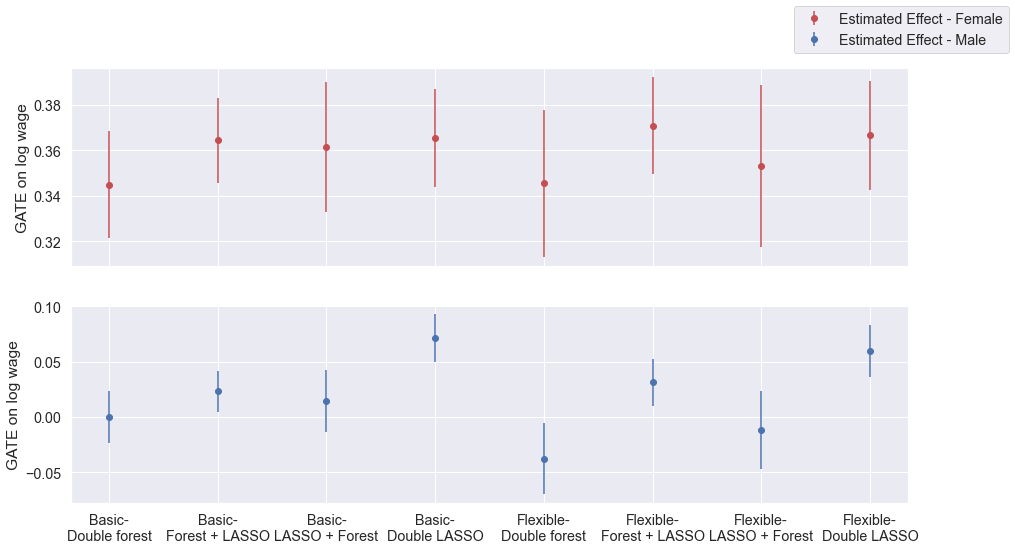

In [ ]:
sensitative_summary_df_wage['D+M'] = sensitative_summary_df_wage.Data + '-\n' + sensitative_summary_df_wage.Model

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(15,8), sharex=True)



ax2.errorbar(sensitative_summary_df_wage['D+M'], sensitative_summary_df_wage['coef-male'], fmt='o',
             yerr=sensitative_summary_df_wage['SE-male'], color = 'b',
             label='Estimated Effect - Male')

ax1.errorbar(sensitative_summary_df_wage['D+M'], sensitative_summary_df_wage['coef-female'], fmt='o',
             yerr=sensitative_summary_df_wage['SE-female'], color = 'r',
             label='Estimated Effect - Female')


f.xlabel = sensitative_summary_df_wage.index

f.xlabel = 'Data & Model'

ax1.set_ylabel('GATE on log wage')
ax2.set_ylabel('GATE on log wage')

#f.subplots_adjust(wspace=0, hspace=0)
plt.xticks()

f.legend()

plt.savefig(output_dir+'\\sensitative_summary_wage'+'.svg')

## employment

In [ ]:
data_wide

,id,treat,female,IQ,KWW,educ,black,south,urban,sibs,...,married_2005,log_wage_2005,wage_2010,hours_2010,emp_2010,exper_2010,tenure_2010,age_2010,married_2010,log_wage_2010
0,1,0,1,105,42,12,0,1,1,3,...,1,6.986104,1446.378622,40,1,13,20,42,1,7.276818
1,2,1,0,85,32,14,1,1,1,5,...,1,0.000000,0.000000,0,0,9,0,33,1,0.000000
2,3,0,1,112,24,14,0,0,1,4,...,1,6.650602,956.093425,40,1,10,9,34,1,6.862856
3,4,0,1,103,30,16,0,0,1,3,...,1,6.907505,1376.737086,45,1,8,3,39,1,7.227472
4,5,0,1,69,18,9,1,1,1,8,...,1,5.926926,654.090458,40,1,21,17,43,1,6.483246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1043,0,1,82,33,18,0,0,1,2,...,0,5.906723,479.221254,49,1,9,12,36,0,6.172162
1043,1044,1,1,101,41,12,0,0,1,1,...,1,6.599870,1264.218137,40,1,4,16,41,1,7.142209
1044,1045,0,0,114,50,18,0,0,1,2,...,1,0.000000,0.000000,0,0,8,0,43,1,0.000000
1045,1046,1,1,115,45,17,0,0,1,3,...,1,6.993015,1600.707821,45,1,4,11,35,1,7.378201


In [ ]:
data_used = data_wide.copy()

outcome_var_emp = 'emp_2010'
exclude_var_emp = ['wage_2010', 'emp_2010']
dummy_var = ['treat', 'female', 'black', 'south', 'urban', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow',
            'married_2005', 'married_2010', 'same_firm_2010', 'highsch', 'college', 'postgrad']
confounder_base_emp = [i for i in data_used.columns if i not in ['id', 'treat', outcome_var_emp, *exclude_var_emp]]
data_emp = power_var_creater(data_used, confounder_base_emp, 2)
data_emp = interaction_creater(data_emp, confounder_base_emp)

confounder_emp = [i for i in data_emp.columns if i not in ['id', 'treat', 'educ_cat', outcome_var_emp, *exclude_var_emp]]
confounder_emp_base = [i for i in data_used.columns if i not in ['id', 'treat', 'educ_cat', outcome_var_emp, *exclude_var_emp]]

100%|████████████████████████████████████████████| 465/465 [00:06<00:00, 66.57it/s]


In [ ]:
confounder_emp_base

['female',
 'IQ',
 'KWW',
 'educ',
 'black',
 'south',
 'urban',
 'sibs',
 'brthord',
 'meduc',
 'feduc',
 'highsch',
 'college',
 'postgrad',
 'feduc_unknown',
 'meduc_unknown',
 'brthord_unknow',
 'wage_2005',
 'hours_2005',
 'emp_2005',
 'exper_2005',
 'tenure_2005',
 'age_2005',
 'married_2005',
 'log_wage_2005',
 'hours_2010',
 'exper_2010',
 'tenure_2010',
 'age_2010',
 'married_2010',
 'log_wage_2010']

In [ ]:
[i for i in confounder_emp if 'KWW' in i]

['KWW',
 'KWW_power2',
 'female_x_KWW',
 'IQ_x_KWW',
 'KWW_x_educ',
 'KWW_x_black',
 'KWW_x_south',
 'KWW_x_urban',
 'KWW_x_sibs',
 'KWW_x_brthord',
 'KWW_x_meduc',
 'KWW_x_feduc',
 'KWW_x_highsch',
 'KWW_x_college',
 'KWW_x_postgrad',
 'KWW_x_feduc_unknown',
 'KWW_x_meduc_unknown',
 'KWW_x_brthord_unknow',
 'KWW_x_wage_2005',
 'KWW_x_hours_2005',
 'KWW_x_emp_2005',
 'KWW_x_exper_2005',
 'KWW_x_tenure_2005',
 'KWW_x_age_2005',
 'KWW_x_married_2005',
 'KWW_x_log_wage_2005',
 'KWW_x_hours_2010',
 'KWW_x_exper_2010',
 'KWW_x_tenure_2010',
 'KWW_x_age_2010',
 'KWW_x_married_2010',
 'KWW_x_log_wage_2010']

In [ ]:
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

lasso_reg = LassoCV(cv=5)
logit_class = LogisticRegressionCV(penalty='l1', solver = 'saga', cv=5) # Penality l1: LASSO, penality l2: Ridge , elasticnet: Elasitc net


data_dml_emp = dml.DoubleMLData(data_emp, y_col = outcome_var_emp, d_cols = 'treat', x_cols = confounder_emp)

dml_emp = dml.DoubleMLIRM(data_dml_emp, ml_g=randomForest_class, ml_m=randomForest_class, score = 'ATE',
                          trimming_threshold=0.01, n_folds=5, apply_cross_fitting = True, n_rep  = 1,
                          normalize_ipw = True)

In [ ]:
%%time
dml_emp.fit(store_predictions=True, n_jobs_cv=-1)

CPU times: total: 0 ns
Wall time: 7.29 s


In [ ]:
print(dml_emp)

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: emp_2010
Treatment variable(s): ['treat']
Covariates: ['female', 'IQ', 'KWW', 'educ', 'black', 'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc', 'highsch', 'college', 'postgrad', 'feduc_unknown', 'meduc_unknown', 'brthord_unknow', 'wage_2005', 'hours_2005', 'emp_2005', 'exper_2005', 'tenure_2005', 'age_2005', 'married_2005', 'log_wage_2005', 'hours_2010', 'exper_2010', 'tenure_2010', 'age_2010', 'married_2010', 'log_wage_2010', 'female_power2', 'IQ_power2', 'KWW_power2', 'educ_power2', 'black_power2', 'south_power2', 'urban_power2', 'sibs_power2', 'brthord_power2', 'meduc_power2', 'feduc_power2', 'highsch_power2', 'college_power2', 'postgrad_power2', 'feduc_unknown_power2', 'meduc_unknown_power2', 'brthord_unknow_power2', 'wage_2005_power2', 'hours_2005_power2', 'emp_2005_power2', 'exper_2005_power2', 'tenure_2005_power2', 'age_2005_power2', 'married_

100%|████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.05it/s]


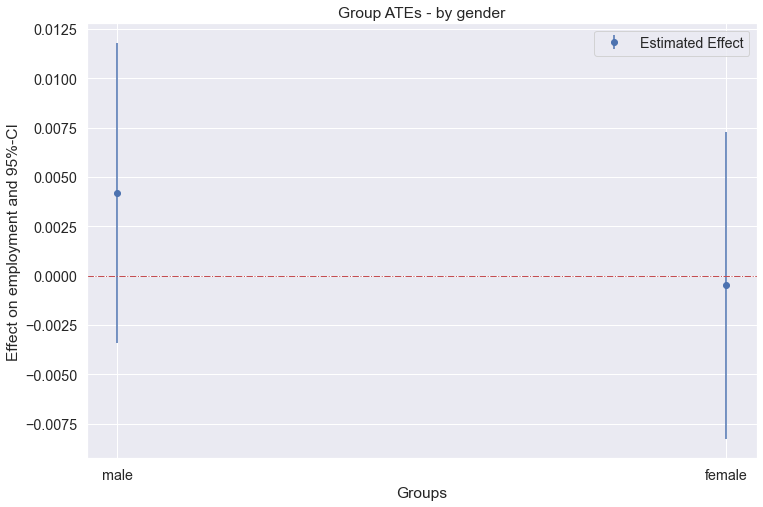

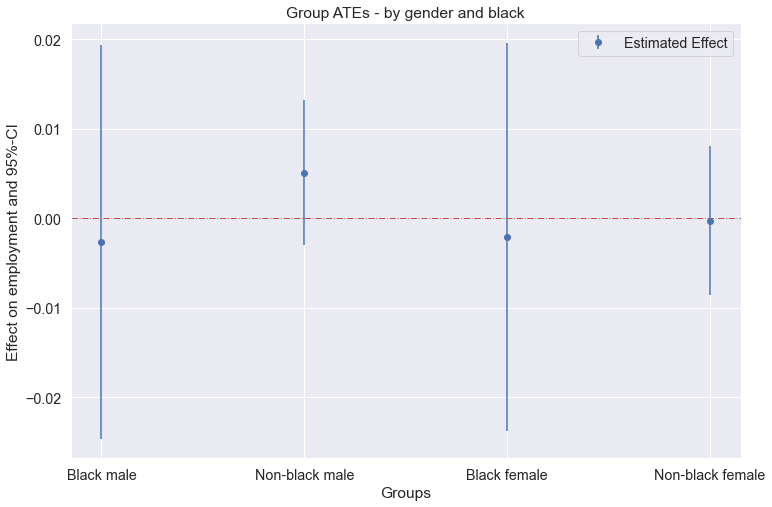

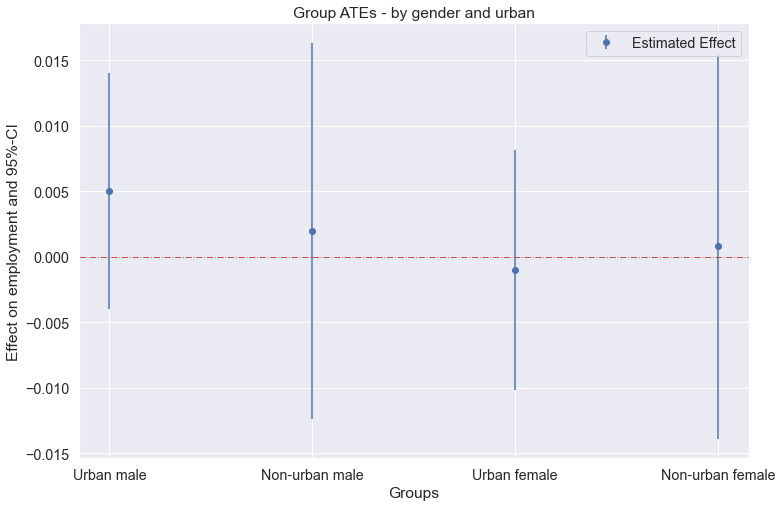

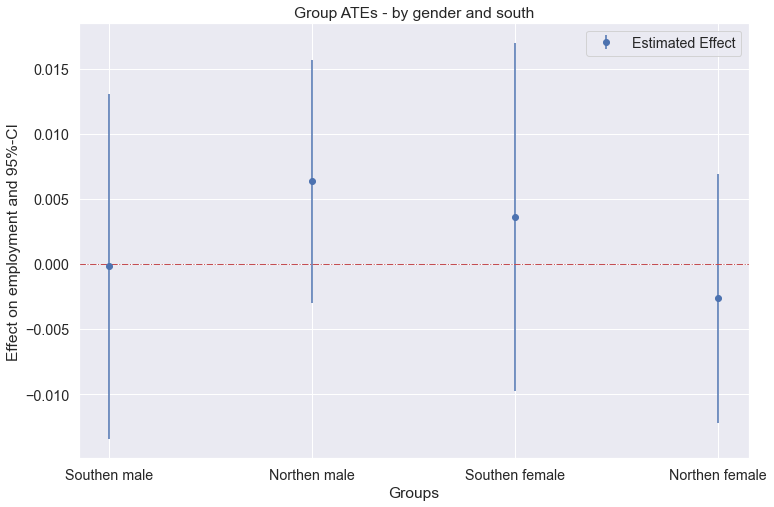

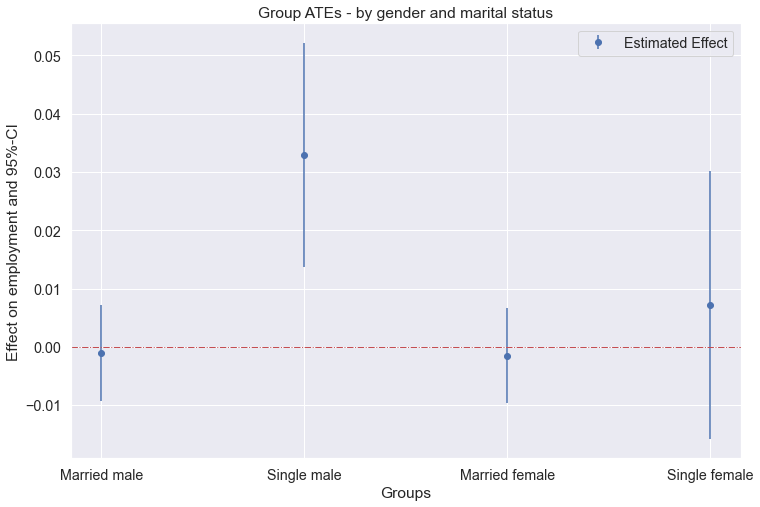

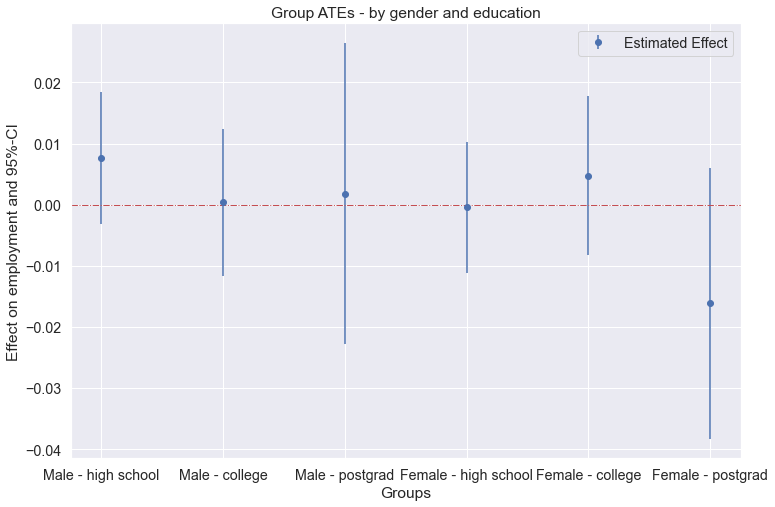

In [ ]:
filtered_index = data_emp.index

groups_dict = {'by gender': by_gender.iloc[filtered_index],
               'by gender and black': by_gender_black.iloc[filtered_index],
               'by gender and urban': by_gender_urban.iloc[filtered_index],
               'by gender and south': by_gender_south.iloc[filtered_index],
               'by gender and marital status': by_gender_married.iloc[filtered_index],
               'by gender and education': by_gender_educ.iloc[filtered_index]}
sum_list = []
fig_list = []

for i in tqdm(groups_dict.keys()):
    gate = dml_emp.gate(groups=groups_dict[i])
    summary = gate.summary
    fig = plt.figure(figsize=(12,8))

    errors = np.full((2, summary.shape[0]), np.nan)
    errors[0, :] = summary['coef'] - summary['[0.025']
    errors[1, :] = summary['0.975]'] - summary['coef']

    plt.errorbar(summary.index, summary.coef, fmt='o', yerr=errors, label='Estimated Effect')

    plt.axhline(y = 0, linestyle = '-.', linewidth = 1, color = 'r')
    plt.title('Group ATEs - '+ i)
    plt.xlabel('Groups')
    plt.legend()
    plt.ylabel('Effect on employment and 95%-CI')
    plt.savefig(output_dir+'\\Effect employment_'+i+'.svg')

    sum_list.append(summary)
    fig_list.append(fig)


In [ ]:
(data_wide[female_cond & postgrad].emp_2010 - data_wide[female_cond & postgrad].emp_2005).value_counts()

 0    61
-1     1
 1     1
dtype: int64

In [ ]:
gate_emp = pd.concat(sum_list)
gate_emp.to_excel(output_dir+'//GATE employment.xlsx')
gate_emp

,coef,std err,t,P>|t|,[0.025,0.975]
male,0.004181,0.003876,1.078683,0.280978,-0.003425,0.011787
female,-0.000499,0.003955,-0.126086,0.899688,-0.008259,0.007262
Black male,-0.002613,0.011205,-0.233213,0.815642,-0.024601,0.019374
Non-black male,0.005106,0.004135,1.234983,0.217115,-0.003007,0.013220
Black female,-0.002085,0.011034,-0.188999,0.850130,-0.023737,0.019566
Non-black female,-0.000264,0.004240,-0.062350,0.950296,-0.008584,0.008055
Urban male,0.005048,0.004581,1.101883,0.270767,-0.003941,0.014037
Non-urban male,0.001983,0.007296,0.271850,0.785791,-0.012333,0.016300
Urban female,-0.001006,0.004667,-0.215521,0.829403,-0.010164,0.008152
Non-urban female,0.000801,0.007471,0.107229,0.914628,-0.013859,0.015461


In [ ]:
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

lasso_reg = LassoCV(cv=5)
logit_class = LogisticRegressionCV(penalty='l1', solver = 'saga', cv=5) # Penality l1: LASSO, penality l2: Ridge , elasticnet: Elasitc net


data_emp_f = data_emp[data_emp.female == 1]
data_dml_emp_f = dml.DoubleMLData(data_emp_f, y_col = outcome_var_emp, d_cols = 'treat', x_cols = confounder_emp)

dml_emp_f = dml.DoubleMLIRM(data_dml_emp_f, ml_g=randomForest_class, ml_m=randomForest_class,
                          trimming_threshold=0.01, n_folds=5, apply_cross_fitting = True, n_rep  = 1,
                          normalize_ipw = True)

In [ ]:
%%time
dml_emp_f.fit(store_predictions=True, n_jobs_cv=-1)

CPU times: total: 0 ns
Wall time: 5.06 s


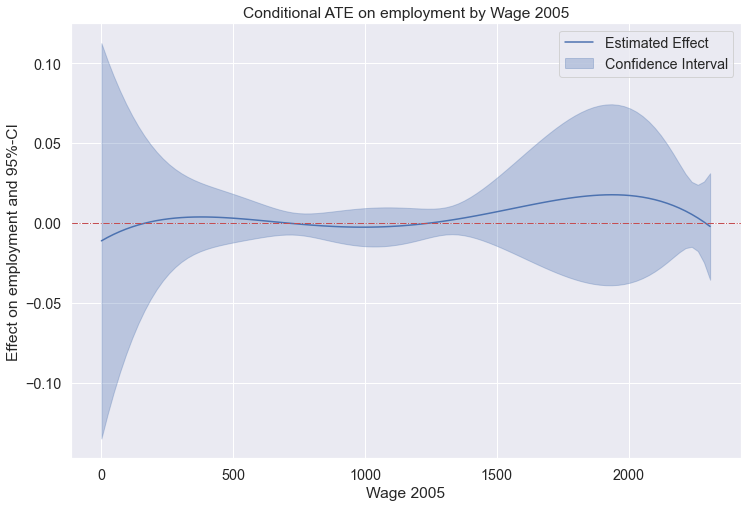

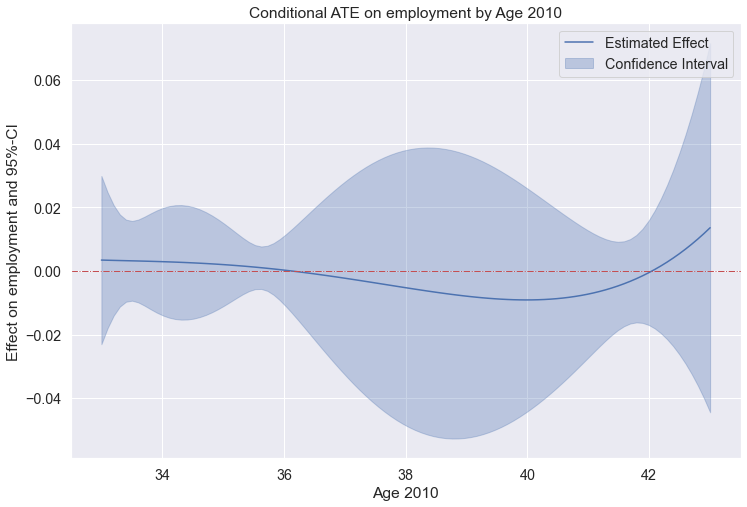

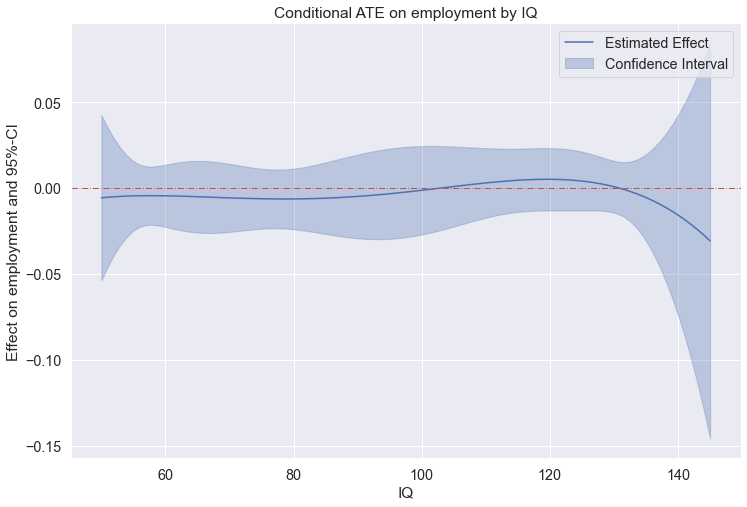

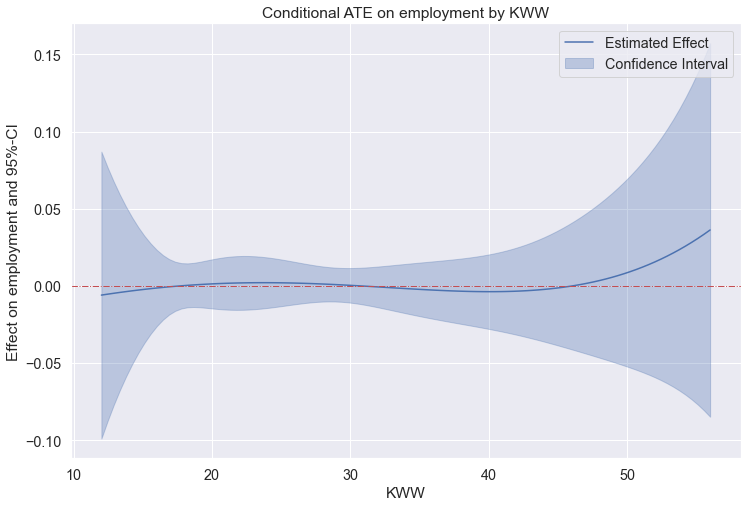

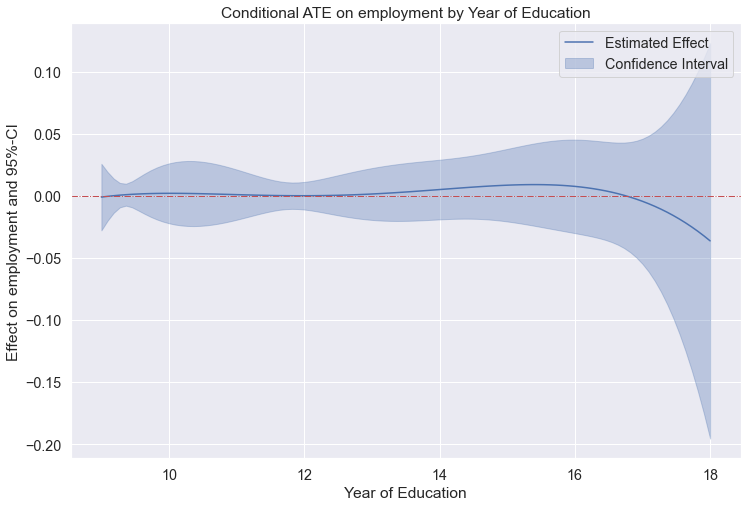

In [ ]:
var_list = ['wage_2005', 'age_2010', 'IQ', 'KWW', 'educ']

title_dict = dict(zip(var_list, ['Wage 2005', 'Age 2010', 'IQ', 'KWW', 'Year of Education']))

cate_list = []

for var in var_list:
    # 4 degree polynomial with 4 degree of freedom

    design_matrix = patsy.dmatrix("bs(x, df=4, degree=4)", {"x":data_emp_f[var]})
    spline_basis = pd.DataFrame(design_matrix)
    cate = dml_emp_f.cate(spline_basis)
    cate_list.append(dml_emp_f.cate(data_emp_f[[var]]))

    new_data = {"x": np.linspace(data_emp_f[var].min(), data_emp_f[var].max(), 100)}
    spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data, NA_action='drop')[0])
    df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)


    plt.rcParams['figure.figsize'] = 10., 7.5

    df_cate['x'] = new_data['x']
    fig = plt.figure(figsize=(12,8))
    plt.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
    plt.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')
    plt.axhline(y = 0, linestyle = '-.', linewidth = 1, color = 'r')


    plt.legend()
    plt.title('Conditional ATE on employment'+' by '+ title_dict[var])
    plt.xlabel(var)
    plt.ylabel('Effect on employment and 95%-CI')
    plt.xlabel(title_dict[var])
    plt.savefig(output_dir+'\\CATE'+var+'.svg')

## Sensititive analysis

In [ ]:
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

lasso_reg = LassoCV(cv=5)
logit_class = LogisticRegressionCV(penalty='l1', solver = 'saga', cv = 5) # Penality l1: LASSO, penality l2: Ridge , elasticnet: Elasitc net


data_dml_emp = dml.DoubleMLData(data_emp, y_col = outcome_var_emp, d_cols = 'treat', x_cols = confounder_emp)
data_dml_emp_base = dml.DoubleMLData(data_emp, y_col = outcome_var_emp, d_cols = 'treat', x_cols = confounder_emp_base)


d_dict = {'Basic': data_dml_emp_base, 'Flexible': data_dml_emp}
model_dict = {'Double forest': [randomForest_reg, randomForest_class], 'Forest + LASSO': [randomForest_reg, logit_class],
              'LASSO + Forest': [lasso_reg, randomForest_class], 'Double LASSO': [lasso_reg, logit_class]}



In [ ]:
name_list = []
summ_list = []
rmse_list = []

for i in d_dict.keys():
    for j in tqdm(model_dict.keys()):
        model = dml.DoubleMLIRM(d_dict[i], ml_g=model_dict[j][0], ml_m=model_dict[j][1],
                          trimming_threshold=0.01, n_folds=5, apply_cross_fitting = True, n_rep  = 1,
                          normalize_ipw = True)
        fit = model.fit(store_predictions=True, n_jobs_cv=-1)
        summ = fit.gate(groups=groups_dict['by gender']).summary
        rmse = fit.evaluate_learners()

        name_list.append((i, j))
        summ_list.append(summ)
        rmse_list.append(rmse)

100%|████████████████████████████████████████████████| 4/4 [02:21<00:00, 35.45s/it]


In [ ]:
sensitative_summary = {'Data': [i[0] for i in name_list], 'Model': [i[1] for i in name_list],
                      'coef-male':[i.loc['male', 'coef'] for i in summ_list],
                      'SE-male':[i.loc['male', 'std err'] for i in summ_list],
                      'coef-female':[i.loc['female', 'coef'] for i in summ_list],
                      'SE-female':[i.loc['female', 'std err'] for i in summ_list],
                      'Out of sample RMSE - g0': [i['ml_g0'][0][0] for i in rmse_list],
                      'Out of sample RMSE - g1': [i['ml_g1'][0][0] for i in rmse_list],
                      'Out of sample RMSE - m': [i['ml_m'][0][0] for i in rmse_list]}

sensitative_summary_df = pd.DataFrame(sensitative_summary)
sensitative_summary_df['Male-female Difference'] = sensitative_summary_df['coef-female'] - sensitative_summary_df['coef-male']
sensitative_summary_df.to_excel(output_dir+'//sensitative_summary_emp.xlsx')
sensitative_summary_df

,Data,Model,coef-male,SE-male,coef-female,SE-female,Out of sample RMSE - g0,Out of sample RMSE - g1,Out of sample RMSE - m,Male-female Difference
0,Basic,Double forest,-0.000185,0.001087,0.001149,0.001109,0.010715,0.015897,0.411218,0.001333
1,Basic,Forest + LASSO,-0.001172,0.001562,0.000910,0.001594,0.023567,0.017074,0.481295,0.002082
2,Basic,LASSO + Forest,0.000401,0.008582,-0.016593,0.008756,0.085088,0.079907,0.412813,-0.016994
3,Basic,Double LASSO,-0.001987,0.007456,-0.020878,0.007607,0.085007,0.076766,0.481856,-0.018891
4,Flexible,Double forest,0.001687,0.002029,-0.000277,0.002070,0.014363,0.023884,0.425558,-0.001964
5,Flexible,Forest + LASSO,-0.000612,0.001401,0.001152,0.001429,0.016079,0.021743,0.480398,0.001763
6,Flexible,LASSO + Forest,-0.013709,0.021023,0.006903,0.021449,0.196924,0.154090,0.417384,0.020612
7,Flexible,Double LASSO,0.019893,0.014879,0.016523,0.015180,0.193951,0.149804,0.479647,-0.003370


In [ ]:
sensitative_summary_df['coef-male']

0   -0.000185
1   -0.001172
2    0.000401
3   -0.001987
4    0.001687
5   -0.000612
6   -0.013709
7    0.019893
Name: coef-male, dtype: float64

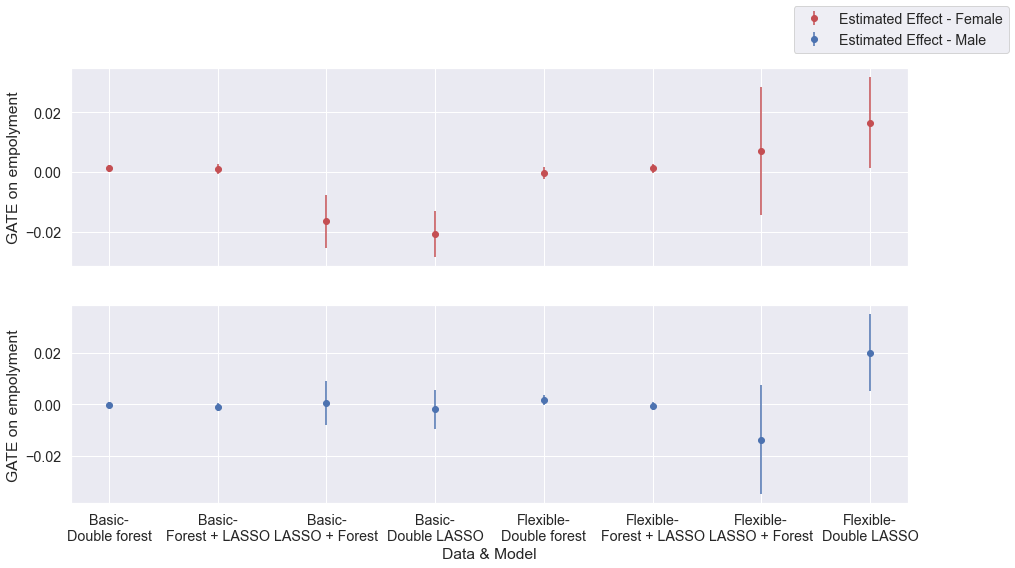

In [ ]:
sensitative_summary_df['D+M'] = sensitative_summary_df.Data + '-\n' + sensitative_summary_df.Model

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(15,8), sharex=True)

ax2.errorbar(sensitative_summary_df['D+M'], sensitative_summary_df['coef-male'], fmt='o',
             yerr=sensitative_summary_df['SE-male'], color = 'b',
             label='Estimated Effect - Male')

ax1.errorbar(sensitative_summary_df['D+M'], sensitative_summary_df['coef-female'], fmt='o',
             yerr=sensitative_summary_df['SE-female'], color = 'r',
             label='Estimated Effect - Female')

f.xlabel = sensitative_summary_df.index

ax1.set_ylabel('GATE on empolyment')
ax2.set_ylabel('GATE on empolyment')

plt.xlabel('Data & Model')
#f.subplots_adjust(wspace=0, hspace=0)
plt.xticks()

f.legend()

plt.savefig(output_dir+'\\sensitative_summary_emp'+'.svg')

In [ ]:
dml_emp.psi_elements['psi_a'].shape

(1047, 1, 1)

In [ ]:
[*dml_emp.psi_elements['psi_b']]

[array([[0.]]),
 array([[-0.02948201]]),
 array([[0.]]),
 array([[0.]]),
 array([[-0.002]]),
 array([[0.]]),
 array([[0.02520387]]),
 array([[0.]]),
 array([[-0.01150583]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[-0.0050514]]),
 array([[0.]]),
 array([[0.]]),
 array([[-0.002]]),
 array([[0.01104258]]),
 array([[0.]]),
 array([[0.]]),
 array([[-0.00233566]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.00020515]]),
 array([[-0.08143407]]),
 array([[0.]]),
 array([[0.00440853]]),
 array([[0.]]),
 array([[0.00120486]]),
 array([[0.]]),
 array([[0.]]),
 array([[-0.002]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.03646128]]),
 array([[-0.02072133]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.004]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.008]]),
 array([[-0.03104114]]),
 array([[0.]]),
 array([